# Model code for Master Thesis - Filip Schulz, s22455
---
The below notebook documents the process of development of Polish Sign Alphabet recognition software. More details avialble in the paper.

In [ ]:
!unzip data.zip -d data

# Imports and Auxilary

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

## Augmentation
* __standard transform__ - simple transformation to prepare the image to go into the network

* __basic augment__ - lightweight augmentation to increase the diversity of the dataset

* __heavy augment__ - more aggressive augmentation. It is intended to simulate more difficult conditions to further increase the robustness of the model

* __custom loader__ - loads images and their labelling metadata. It extracts the bounding box size from the XML size and crops the image to this size. It is done in order to cut out unnecessary background elements from the image.

* __apply augmentation__ - loads the images and applies standard transformation. For training data it appends the training dataset with the augmented images.


In [ ]:
standard_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

basic_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

heavy_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=30, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def custom_loader(path):
    image = Image.open(path).convert("RGB")
    xml_path = os.path.splitext(path)[0] + '.xml'
    tree = ET.parse(xml_path)
    root = tree.getroot()
    obj = root.find('object')
    bndbox = obj.find('bndbox')
    xmin, ymin, xmax, ymax = [int(bndbox.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
    return image.crop((xmin, ymin, xmax, ymax))

def apply_augmentation(image_path, label, classes, is_training=True):
    image = custom_loader(image_path)
    images = [standard_transform(image)]
    if is_training:
        images.append(basic_augment(image))
        images.append(heavy_augment(image))
    return images, classes.index(label)


## Dataset splitting
* __train__ - 70%
* __Validation__ - 15%
* __Test__ - 15%

In [ ]:
dataset_root = './data/PSL_Collected_Data'
image_paths = []
labels = []
classes = sorted(os.listdir(dataset_root))

# To ensure that the image will be paired with the corresponding class label
for cls in classes:
    cls_path = os.path.join(dataset_root, cls)
    if os.path.isdir(cls_path):
        for file in os.listdir(cls_path):
            if file.lower().endswith(('.jpg')):
                image_paths.append(os.path.join(cls_path, file))
                labels.append(cls)

print(f"Total images: {len(image_paths)}")
print("Classes:", classes)

# random split
np.random.seed(42)
indices = np.random.permutation(len(image_paths))

train_split = int(0.7 * len(indices))
val_split = int(0.15 * len(indices))

train_idx = indices[:train_split]
val_idx = indices[train_split:train_split + val_split]
test_idx = indices[train_split + val_split:]

train_images = [image_paths[i] for i in train_idx]
train_labels = [labels[i] for i in train_idx]

val_images = [image_paths[i] for i in val_idx]
val_labels = [labels[i] for i in val_idx]

test_images = [image_paths[i] for i in test_idx]
test_labels = [labels[i] for i in test_idx]


Total images: 1200
Classes: ['A', 'B', 'C', 'CH', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'SZ', 'T', 'U', 'W', 'Y', 'Z']


## Actual train/val/test data creation
Takes the splitted images and their labels, applies basic transformation to them and saves the actual train/val/test arrays.
</br>
In case of training data it applies additional augmentation and adds the results to the data to extend it.

In [ ]:
train_data = []
for img_path, lbl in zip(train_images, train_labels):
    augmented, lbl_idx = apply_augmentation(img_path, lbl, classes, is_training=True)
    for img in augmented:
        train_data.append((img, lbl_idx))

val_data = []
for img_path, lbl in zip(val_images, val_labels):
    augmented, lbl_idx = apply_augmentation(img_path, lbl, classes, is_training=False)
    for img in augmented:
        val_data.append((img, lbl_idx))

test_data = []
for img_path, lbl in zip(test_images, test_labels):
    augmented, lbl_idx = apply_augmentation(img_path, lbl, classes, is_training=False)
    for img in augmented:
        test_data.append((img, lbl_idx))

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

Train: 2520 | Val: 180 | Test: 180


## Data Loaders
Adds batch processing, parallelized loading and data shuffle between epochs (only for training)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

## Visualization of augmented data

3 images of augmented data from each class

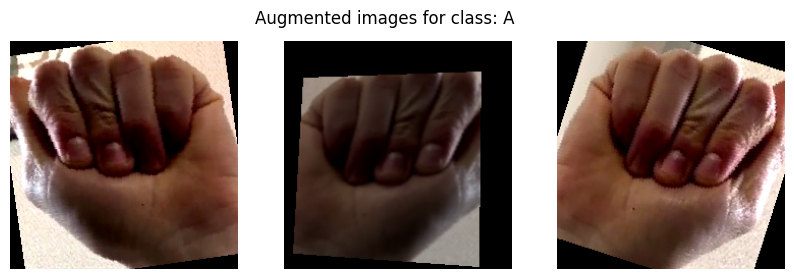

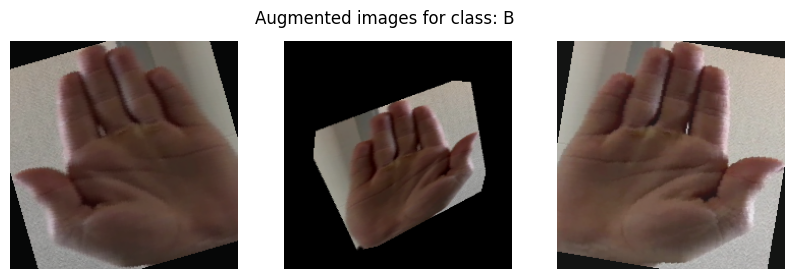

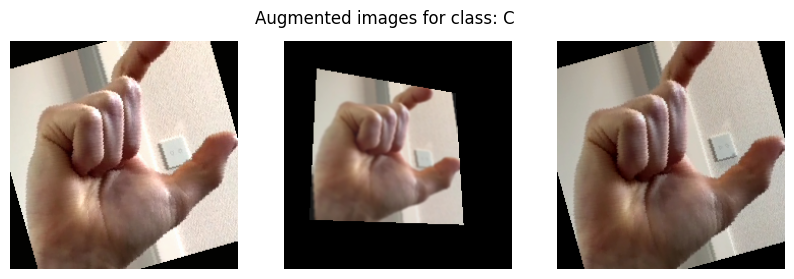

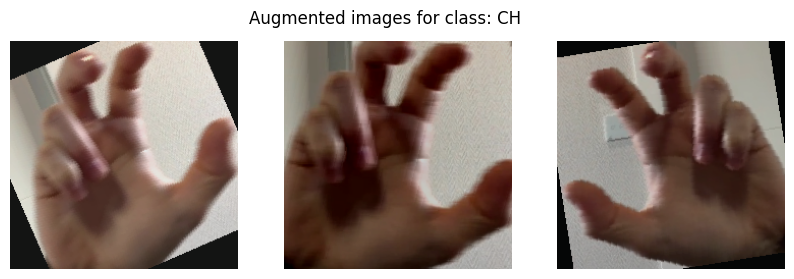

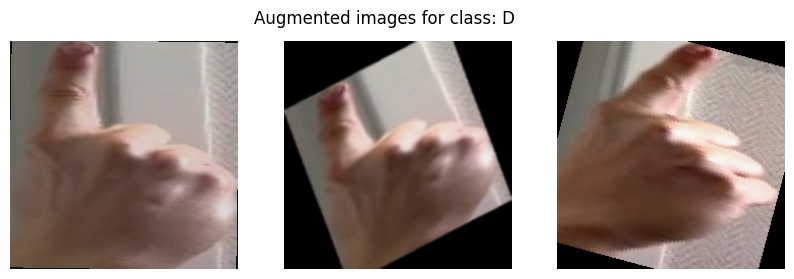

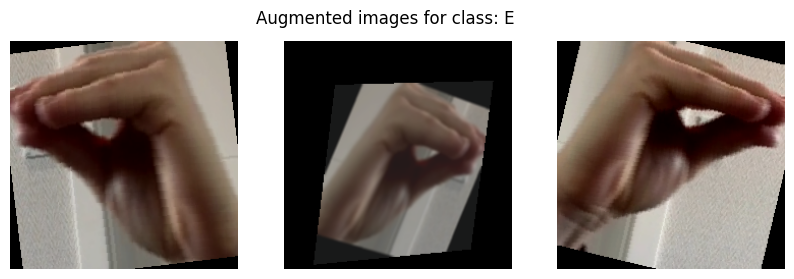

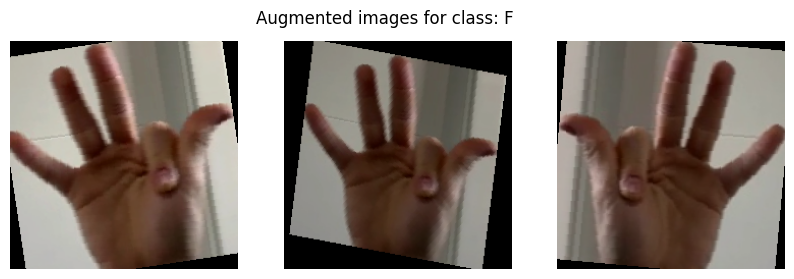

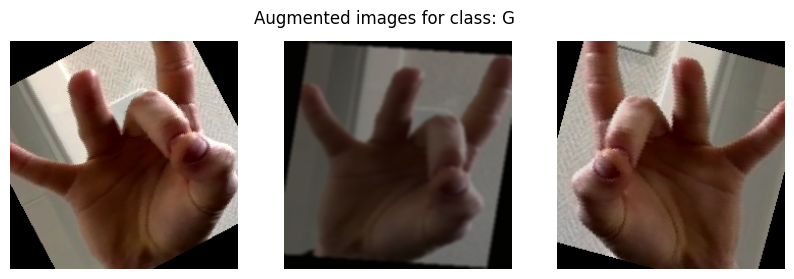

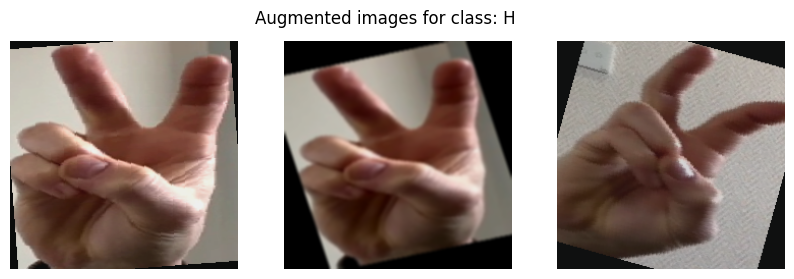

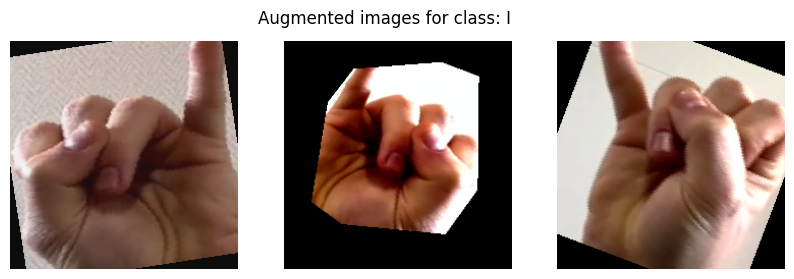

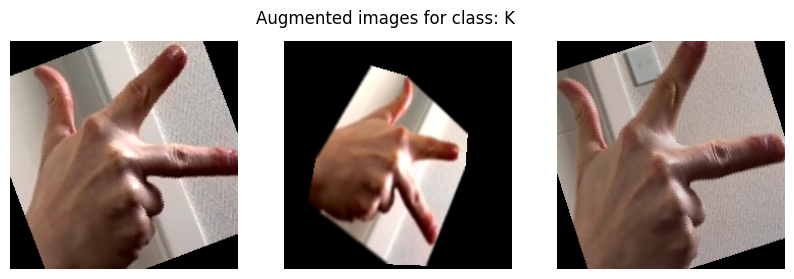

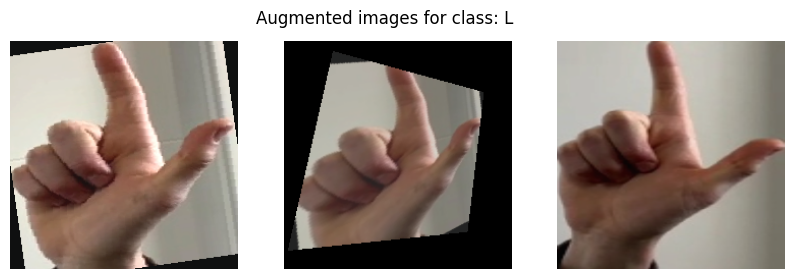

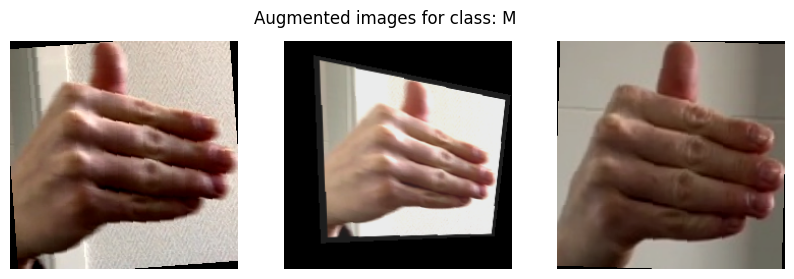

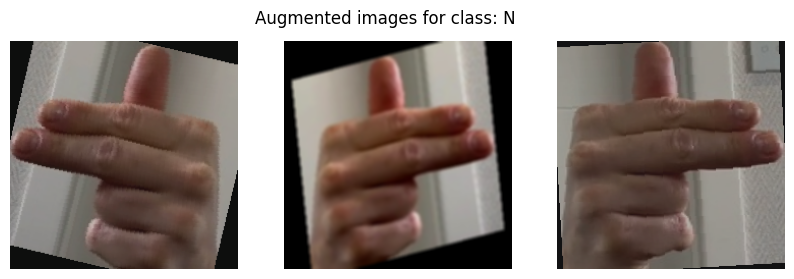

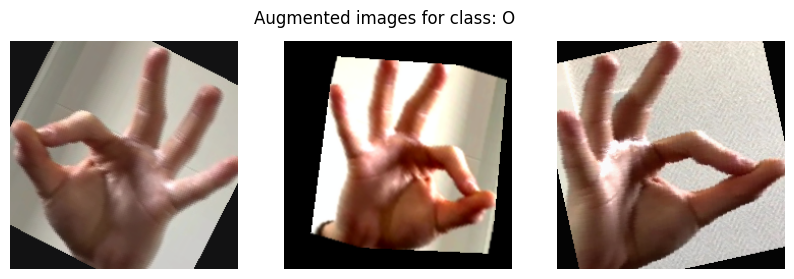

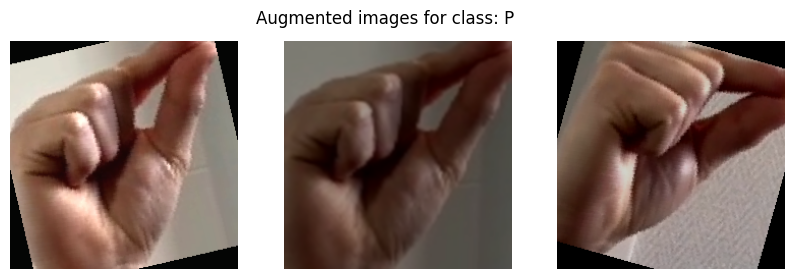

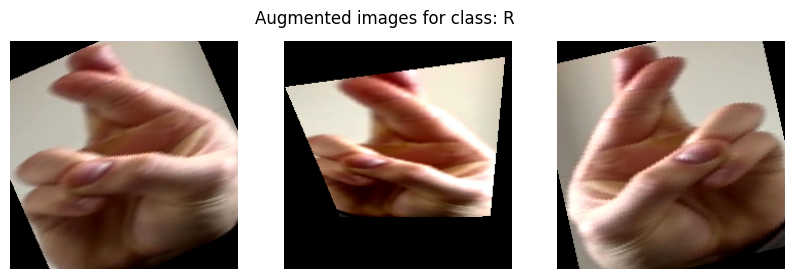

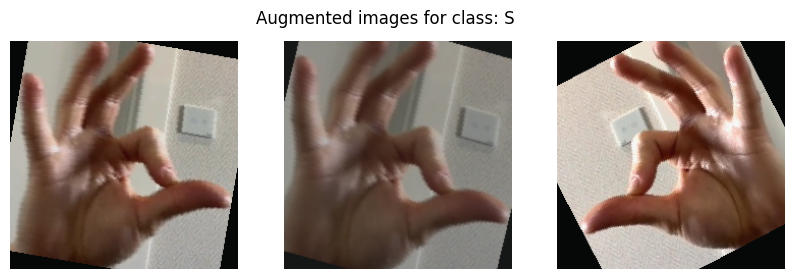

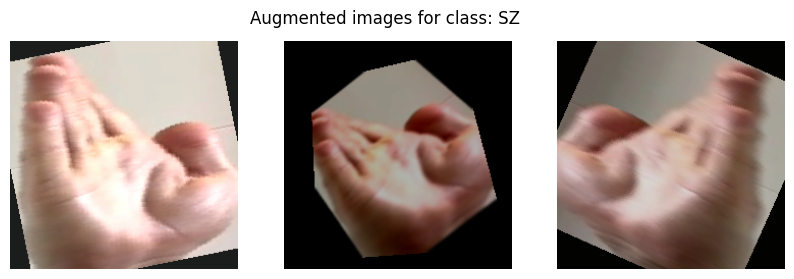

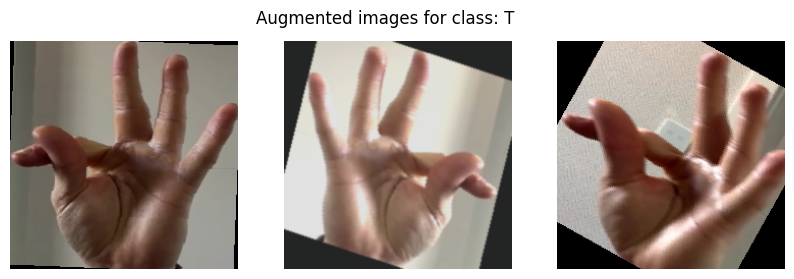

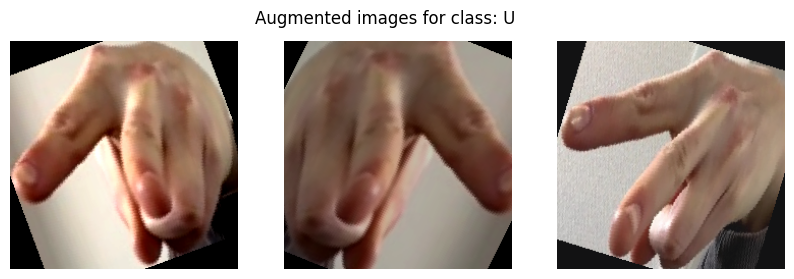

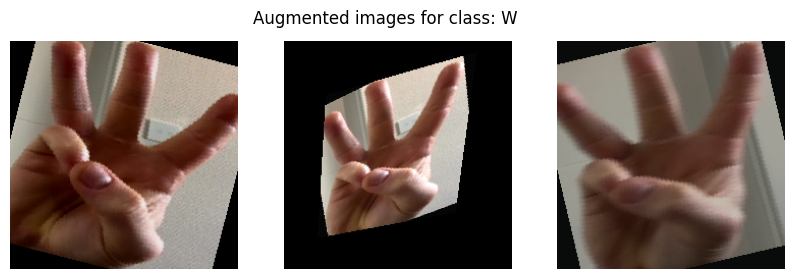

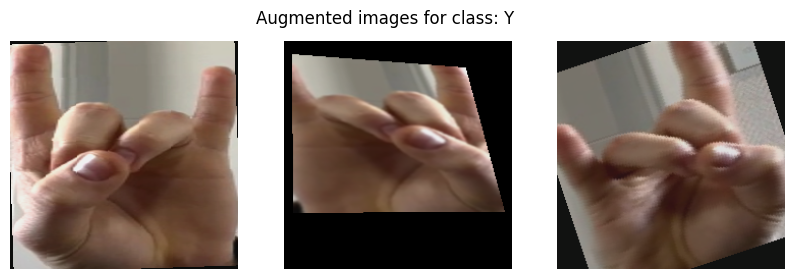

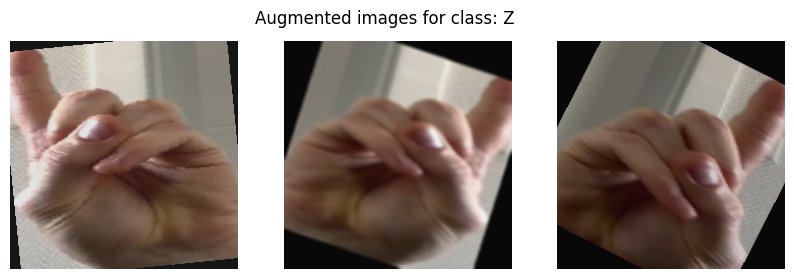

In [ ]:
augmented_images_by_class = {cls: [] for cls in classes}

for img_path, lbl in zip(train_images, train_labels):
    if len(augmented_images_by_class[lbl]) >= 3: # Augment 3 images for each class
        continue

    augmented_imgs, _ = apply_augmentation(img_path, lbl, classes, is_training=True)
    augmented_images_by_class[lbl].extend(augmented_imgs[1:4]) # Skip not augmented image and take 3 augmented ones

    if all(len(v) >= 3 for v in augmented_images_by_class.values()): # stop when we have collected 3 images for each class
        break


def prepare_img_to_display(img_tensor): # Reverse the process done during the standard transformation to allow the image to be displayed in the graph
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Show images
for cls, imgs in augmented_images_by_class.items():
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for ax, img in zip(axes, imgs[:3]):
        ax.imshow(prepare_img_to_display(img))
        ax.axis("off")
    fig.suptitle(f"Augmented images for class: {cls}")
    plt.show()


# Model
1. Loads pretrained MobileNetV2 model
2. Freezes the convolutional layers. This prevents the layers from updating weights. This is was done in order to prevent overfitting due to relatively small dataset. Unfortunately without that, the network was completely unable of generalization.
3. Replace final layer with a new one, adjusted to number of classified classes (24) + dropout to further prevent overfitting

In [ ]:
model = models.mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

num_classes = len(classes)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


## Training config

* __Cross entropy__ - often used loss for multiple class classification tasks
* __Adam optimizer__ - also often used. Adjusted learning rate + L2 regularization
* __Scheduler__ - dynamically adjusts the learning rate (reduces it by 0.1 if loss doesn't improve within 3 epochs)
* __20 epochs__ - number obtained by trial and error with early stopping. More epochs yielded no significant improvement yet significantly increased training time.

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

num_epochs = 20

# basic config of early stopping (turns out PyTorch doesn't have a native implementation)
patience = 5
best_val_loss = float('inf')
patience_counter = 0
delta = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


## Training

In [ ]:
for epoch in range(num_epochs):
    model.train() # Switch to training mode
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # Clear previous gradients
        outputs = model(images) # make prediction
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # apply backpropagation
        optimizer.step() # update model's parameters

        # Metrics gathering
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval() # Switch to evaluation mode
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad(): # turn off gradient calculation for evaluation (unnecessary and wastes resources)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # make prediction
            loss = criterion(outputs, labels) # compute loss

            # Metrics
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # More metrics - for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss) # update learning rate

    # Early stopping check + trigger
    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Early Stopping: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Training got stopped early.")
            break


Epoch 1/20 | Train Loss: 3.0026 | Val Loss: 2.6879 | Val Acc: 0.5333
Epoch 2/20 | Train Loss: 2.7166 | Val Loss: 2.4236 | Val Acc: 0.7222
Epoch 3/20 | Train Loss: 2.4922 | Val Loss: 2.1640 | Val Acc: 0.8444
Epoch 4/20 | Train Loss: 2.2969 | Val Loss: 1.9643 | Val Acc: 0.8944
Epoch 5/20 | Train Loss: 2.1035 | Val Loss: 1.7900 | Val Acc: 0.9111
Epoch 6/20 | Train Loss: 1.9723 | Val Loss: 1.6311 | Val Acc: 0.9167
Epoch 7/20 | Train Loss: 1.8415 | Val Loss: 1.5179 | Val Acc: 0.9111
Epoch 8/20 | Train Loss: 1.7251 | Val Loss: 1.4234 | Val Acc: 0.9222
Epoch 9/20 | Train Loss: 1.6228 | Val Loss: 1.3306 | Val Acc: 0.9278
Epoch 10/20 | Train Loss: 1.5648 | Val Loss: 1.2690 | Val Acc: 0.9389
Epoch 11/20 | Train Loss: 1.4809 | Val Loss: 1.2131 | Val Acc: 0.9444
Epoch 12/20 | Train Loss: 1.4341 | Val Loss: 1.1579 | Val Acc: 0.9556
Epoch 13/20 | Train Loss: 1.3807 | Val Loss: 1.1164 | Val Acc: 0.9556
Epoch 14/20 | Train Loss: 1.3361 | Val Loss: 1.0797 | Val Acc: 0.9667
Epoch 15/20 | Train Loss: 1.3

# Evaluation

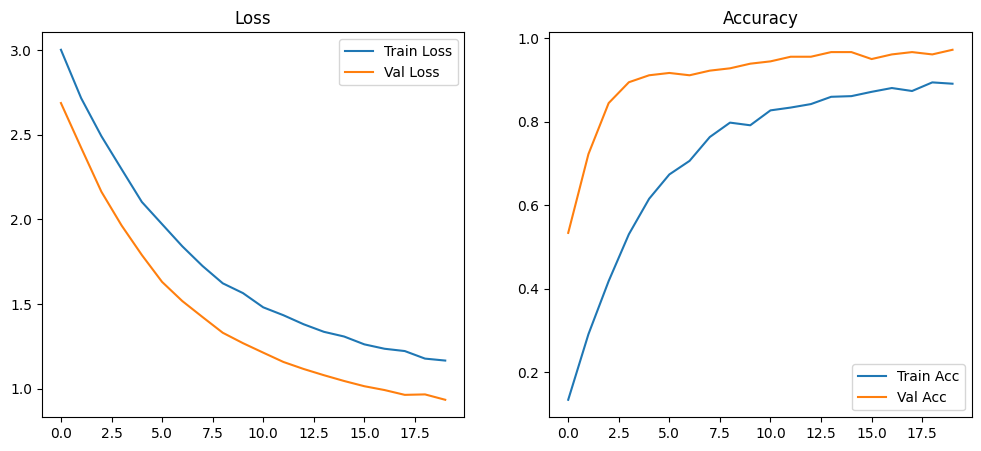

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.eval()
test_correct, test_total, test_loss = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9778


In [ ]:
report = classification_report(all_labels, all_preds, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         5
           C       1.00      1.00      1.00         6
          CH       1.00      1.00      1.00         6
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00         7
           F       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         8
           H       0.86      1.00      0.92         6
           I       1.00      1.00      1.00         7
           K       1.00      1.00      1.00         6
           L       1.00      1.00      1.00         7
           M       1.00      1.00      1.00        11
           N       1.00      1.00      1.00         7
           O       0.80      1.00      0.89         8
           P       1.00      1.00      1.00        10
           R       1.00      1.00      1.00         6
   

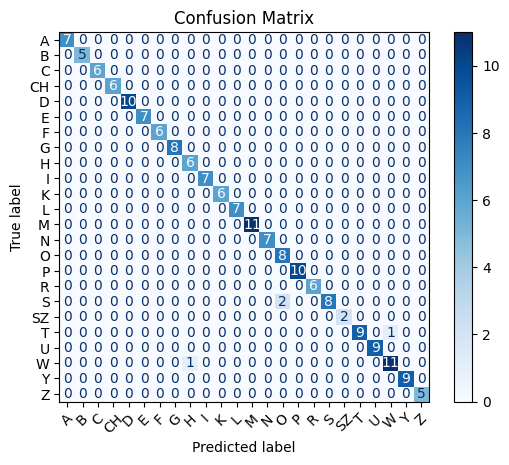

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'mobileNetV2_psl.pth')
print("Model saved")

Model saved
